In [49]:
!pip uninstall tensorflow
!pip install tensorflow==2.3

Found existing installation: tensorflow 2.6.0+zzzcolab20220506153740
Uninstalling tensorflow-2.6.0+zzzcolab20220506153740:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.6.0+zzzcolab20220506153740.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.6.0+zzzcolab20220506153740
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320.4 MB 52 kB/s 
     |████████████████████████████████| 2.9 MB 7.8 MB/s 
     |████████████████████████████████| 459 kB 57.9 MB/s 
     |████████████████████████████████| 20.1 MB 27.8 MB/s 
  Attempting u

In [2]:
import tensorflow
tensorflow.__version__

'2.3.0'

In [3]:
!pip install bert-for-tf2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
# sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
!pwd

/content


In [5]:
data = pd.read_csv('dataset_intent.csv')

In [6]:
from sklearn.utils import shuffle
data = shuffle(data)

In [7]:
data.head()

,Intent,Text
290,toggleSideBarVisibility,toggle sidebar visibility
357,focusAboveEditorGroup,focus upward editor group
261,stepOutsideDefinition,exit function definition
157,openPreviousFile,switch previous tab
145,closeFile,current file close


In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


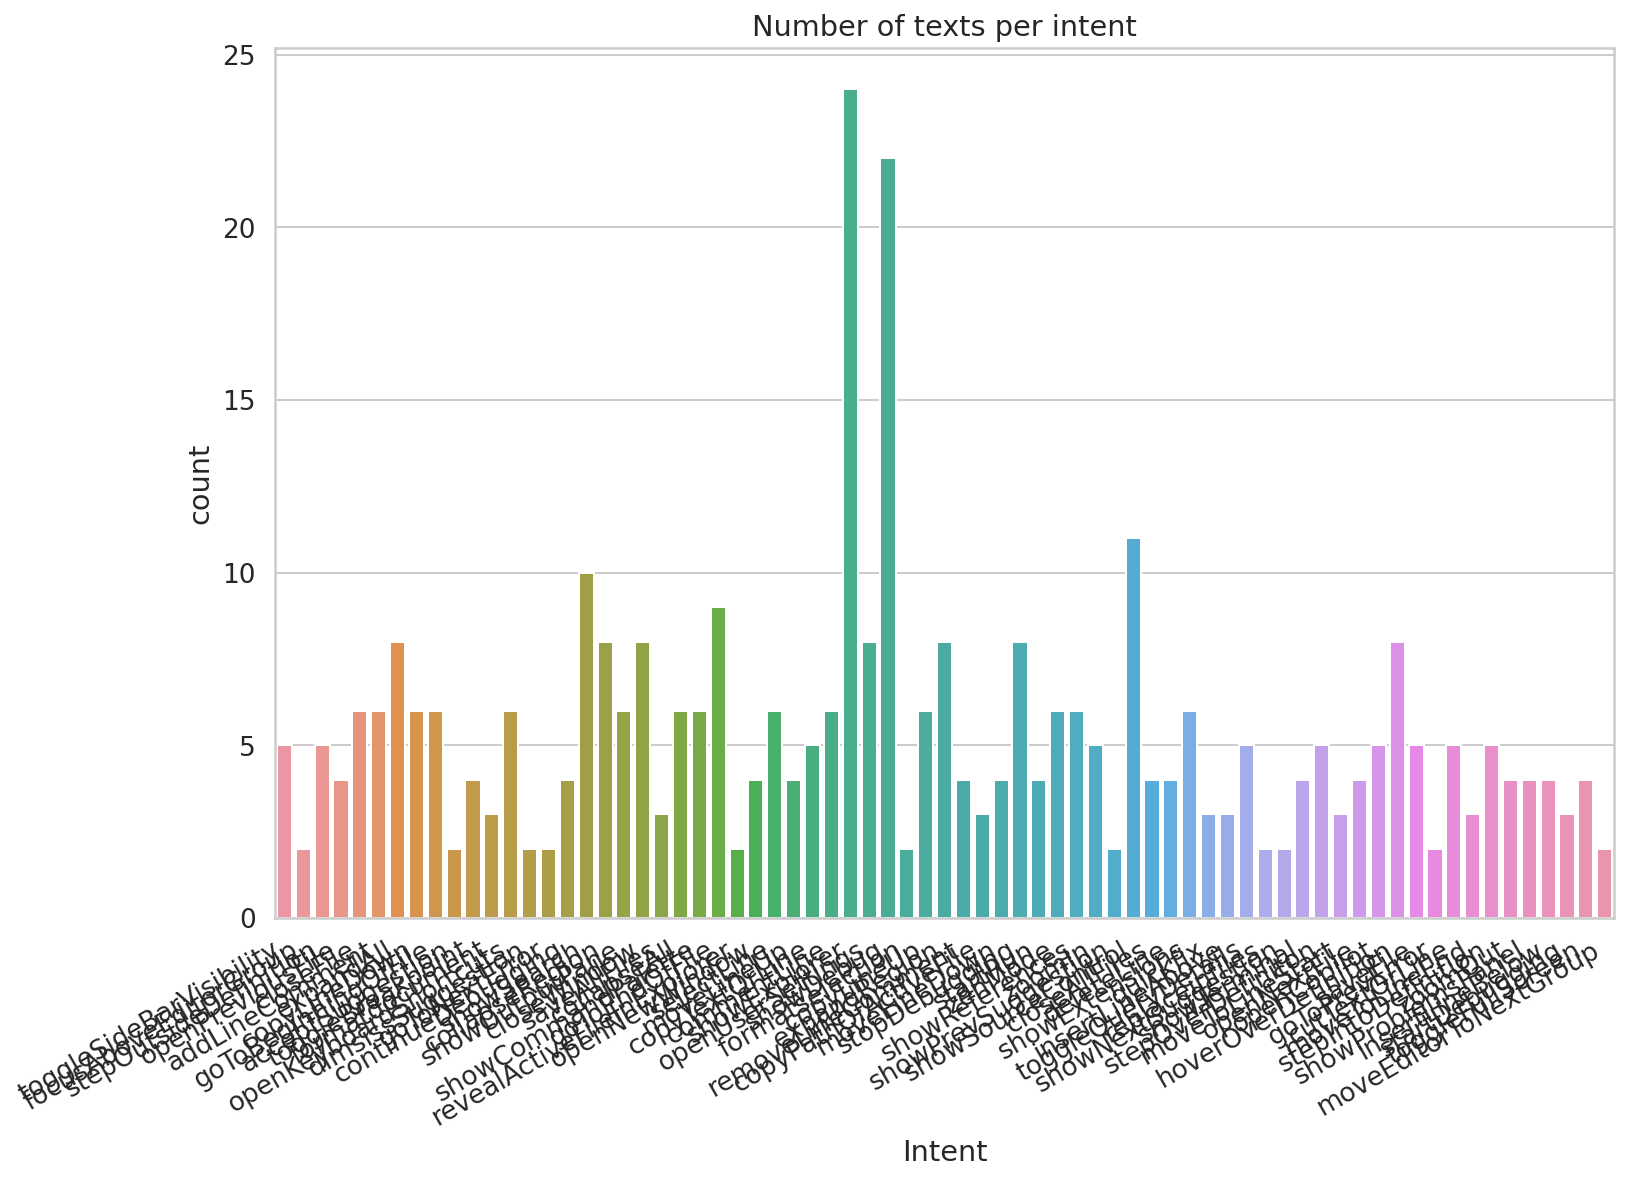

In [9]:
chart = sns.countplot(data.Intent)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [10]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2022-06-23 16:49:25--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.148.128, 172.217.212.128, 142.251.6.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.148.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip.1’

uncased_L-12_H-768_ 100%[===================>] 388.84M   113MB/s    in 3.4s    

2022-06-23 16:49:28 (114 MB/s) - ‘uncased_L-12_H-768_A-12.zip.1’ saved [407727028/407727028]



In [10]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [11]:
os.makedirs("model", exist_ok=True)

In [12]:
!mv uncased_L-12_H-768_A-12/ model

In [11]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

In [12]:
class IntentDetectionData:
  DATA_COLUMN = "Text"
  LABEL_COLUMN = "Intent"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [13]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [14]:
tokenizer.tokenize("Aneesh test tokenizer for Intent's (intentionally written wrong) Detection")

['an',
 '##ees',
 '##h',
 'test',
 'token',
 '##izer',
 'for',
 'intent',
 "'",
 's',
 '(',
 'intentionally',
 'written',
 'wrong',
 ')',
 'detection']

In [15]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model


In [16]:
classes = train.Intent.unique().tolist()
data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=128)

300it [00:00, 4552.51it/s]
76it [00:00, 4083.04it/s]

max seq_len 10


In [17]:
data.train_x.shape

(300, 10)

In [18]:
data.train_x[0]

array([ 101, 7615, 2783, 2240,  102,    0,    0,    0,    0,    0])

In [19]:
data.train_y[0]

0

In [20]:
data.max_seq_len

10

In [21]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 10, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7efde9d4fcd0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [22]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 10)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 10, 768)           108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 71)               

In [23]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [24]:
# for tensorboard
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

In [26]:
history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=100,
  callbacks=[tensorboard_callback]
)

Epoch 1/100
17/17 [==============================] - 62s 4s/step - loss: 4.2041 - acc: 0.0889 - val_loss: 4.1097 - val_acc: 0.1667
Epoch 2/100
17/17 [==============================] - 43s 3s/step - loss: 4.1821 - acc: 0.1074 - val_loss: 4.0837 - val_acc: 0.2000
Epoch 3/100
17/17 [==============================] - 45s 3s/step - loss: 4.1749 - acc: 0.1222 - val_loss: 4.0820 - val_acc: 0.2000
Epoch 4/100
17/17 [==============================] - 43s 3s/step - loss: 4.1608 - acc: 0.1333 - val_loss: 4.0792 - val_acc: 0.2000
Epoch 5/100
17/17 [==============================] - 44s 3s/step - loss: 4.1514 - acc: 0.1296 - val_loss: 4.0743 - val_acc: 0.2000
Epoch 6/100
17/17 [==============================] - 44s 3s/step - loss: 4.1475 - acc: 0.1444 - val_loss: 4.0755 - val_acc: 0.2000
Epoch 7/100
17/17 [==============================] - 43s 3s/step - loss: 4.1347 - acc: 0.1667 - val_loss: 4.0819 - val_acc: 0.2000
Epoch 8/100
17/17 [==============================] - 44s 3s/step - loss: 4.1232 - a

In [27]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

3/3 [==============================] - 2s 541ms/step - loss: 3.5424 - acc: 0.7632
train acc 0.8933333158493042
test acc 0.7631579041481018


In [28]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [38]:
labels = [i for i in range(72)]

In [39]:
print(classification_report(data.test_y, y_pred, target_names=classes, labels = labels))

                            precision    recall  f1-score   support

               commentLine       1.00      1.00      1.00         2
            showExtensions       1.00      1.00      1.00         2
          openUserSettings       1.00      1.00      1.00         2
            showOutputPane       1.00      1.00      1.00         1
              showExplorer       1.00      1.00      1.00         3
        showCommandPalette       0.00      0.00      0.00         0
                selectLine       0.00      0.00      0.00         0
               openCopilot       0.00      0.00      0.00         0
              expandRegion       1.00      1.00      1.00         3
     stepOutsideDefinition       0.00      0.00      0.00         0
         showSourceControl       1.00      1.00      1.00         1
               collapseAll       1.00      1.00      1.00         2
                 showDebug       1.00      1.00      1.00         4
       goToBeginningOfFile       0.00      0.00

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:2128: UserWarning: labels size, 72, does not match size of target_names, 71
  len(labels), len(target_names)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use

In [52]:
# cm = confusion_matrix(data.test_y, y_pred)
# df_cm = pd.DataFrame(cm, index=classes, columns=classes)

In [53]:
# hmap = sns.heatmap(df_cm, annot=True, fmt="d")
# hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
# hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
# plt.ylabel('True label')
# plt.xlabel('Predicted label');

In [54]:
sentences = [
  "Display all commands",
  "Make a copy of the word",
  "move to the next line",
  "select everything",
  "I like this suggestion",
  "I do not like this suggestion",
  "switch query view",
  "show me keyboard bindings"
]

pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nintent:", classes[label])
  print()

text: Display all commands 
intent: showCommandPalette

text: Make a copy of the word 
intent: copyTextOrLine

text: move to the next line 
intent: moveLineDown

text: select everything 
intent: selectLine

text: I like this suggestion 
intent: acceptSuggestion

text: I do not like this suggestion 
intent: acceptSuggestion

text: switch query view 
intent: toggleQueryDetails

text: show me keyboard bindings 
intent: openKeyboardShortcuts



In [57]:
model.save('intent_custom_model.h5')

In [59]:
from google.colab import files
files.download('./intent_custom_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>